In [10]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# -------------------------
# 1. Load flat samples and lnprob
# -------------------------

# CHANGE filenames if needed
flat_samples = np.load("mcmc_results/d13c_sens_test_sclim_4.npy")         # shape (n_steps * n_walkers, ndim)
lnprob_flat  = np.loadtxt("mcmc_results/ln_d13c_sens_test_sclim_4.dat")   # shape (n_steps * n_walkers,)

n_walkers = 48
n_steps   = 8000

n_total, ndim = flat_samples.shape
assert n_total == n_walkers * n_steps, "Shape mismatch, check n_walkers/n_steps."

# Reshape back to emcee-style chain: (n_steps, n_walkers, ndim)
chain = flat_samples.reshape((n_steps, n_walkers, ndim))
lnprob = lnprob_flat.reshape((n_steps, n_walkers))

# -------------------------
# 2. Compute integrated autocorrelation times
# -------------------------
# emcee expects shape (n_steps, n_walkers, ndim) for get_autocorr_time
try:
    tau = emcee.autocorr.integrated_time(chain, tol=0)
    print("Integrated autocorrelation times per parameter:", tau)
    tau_max = np.max(tau)
    print("Max tau =", tau_max)
except Exception as e:
    print("Autocorrelation time estimation failed:", e)
    tau = None
    tau_max = None


Integrated autocorrelation times per parameter: [79.33707751 82.43312197 79.91564678 90.36057084 85.08173305 78.5896204
 83.84989426 80.08904828 89.73090406 78.64896788 77.06868111 86.59872013]
Max tau = 90.36057084395843


In [11]:

# -------------------------
# 3. Choose burn-in and thinning based on tau_max
# -------------------------
if tau_max is not None:
    burnin = int(5 * tau_max)        # e.g. 5×max τ as burn-in
    thin   = max(1, int(0.5 * tau_max))  # optional thinning

    print(f"Suggested burn-in steps: {burnin}")
    print(f"Suggested thinning factor: {thin}")

    # Check that chain is long enough
    print(f"n_steps = {n_steps}, 50*tau_max = {50*tau_max}")
else:
    burnin = 0
    thin = 1


Suggested burn-in steps: 451
Suggested thinning factor: 45
n_steps = 8000, 50*tau_max = 4518.0285421979215


In [16]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
# Set font and set mathtext font the same with text font
mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
mpl.rcParams['mathtext.default'] = 'regular'
# Set tick size globally
# Set tick size globally
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['legend.fontsize'] = 14
plt.close("all")


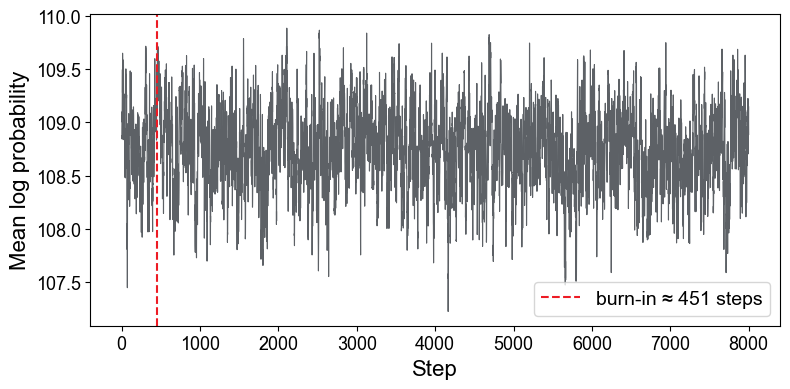

In [18]:

# -------------------------
# 4. Create a log-probability trace plot for SI
# -------------------------

# Mean log-probability across walkers per step
lnprob_mean = lnprob.mean(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(n_steps), lnprob_mean, lw=0.8, color = '#343a40', alpha = 0.8)
if tau_max is not None:
    plt.axvline(burnin,  ls="--", label=f"burn-in ≈ {burnin} steps", color = '#ED1B24')
plt.xlabel("Step")
plt.ylabel("Mean log probability")
# plt.title("MCMC convergence diagnostic: log-probability trace")
plt.legend()
plt.tight_layout()
plt.savefig("fig_logprob_trace.png", dpi=300)
plt.show()


In [13]:

# -------------------------
# 5. Build the post–burn-in, thinned chain and compute effective samples
# -------------------------
thin = 1
post_chain = chain[burnin::thin, :, :]         # shape (n_post_steps, n_walkers, ndim)
n_post_steps = post_chain.shape[0]
n_samples_eff = n_post_steps * n_walkers

print(f"Post–burn-in steps per walker: {n_post_steps}")
print(f"Total post–burn-in samples (before autocorr correction): {n_samples_eff}")

if tau_max is not None and tau_max > 0:
    n_eff_per_param = n_samples_eff / (2.0 * tau)   # very rough rule-of-thumb
    print("Approximate effective sample sizes per parameter:", n_eff_per_param)

Post–burn-in steps per walker: 7549
Total post–burn-in samples (before autocorr correction): 362352
Approximate effective sample sizes per parameter: [2283.62331557 2197.85440219 2267.09045461 2005.03381406 2129.43476226
 2305.34260219 2160.71828826 2262.18195744 2019.10369555 2303.60302078
 2350.83820561 2092.13253658]
